In [37]:
#Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# preprocessing libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline 
# machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
#import optuna as optuna # for hyperparameter tuning
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
# regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
# tree-based algorithms
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#import shape # for model interpretability
import sys
sys.path.append('../../src')
from EvaluateRegression import evaluate_regression
import shap

In [38]:
# Load dataset
df = pd.read_csv("../../data/X_train_preprocessed.csv")

In [39]:
# Define features and target
target = "PrimeCommerciale"
X = df.drop(columns=[target])
y = df[target]

In [40]:
# Identify numeric and categorical columns
var_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
var_cat = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [41]:
# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), var_num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), var_cat)
])

---
Train Model
---

In [42]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [43]:
# ===========================
# Linear Regression Model
# ===========================
lin_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

print("=== Linear Regression ===")
evaluate_regression(y_test, y_pred_lr)


# ===========================
# Ridge Regression Model
# ===========================
ridge = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("\n=== Ridge Regression ===")
evaluate_regression(y_test, y_pred_ridge)


# ===========================
# Lasso Regression Model
# ===========================
lasso = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', Lasso(alpha=0.01))
])

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("\n=== Lasso Regression ===")
evaluate_regression(y_test, y_pred_lasso)


# ===========================
# Random Forest Regressor
# ===========================
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest Regressor ===")
evaluate_regression(y_test, y_pred_rf)


# ===========================
# XGBoost Regressor
# ===========================
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n=== XGBoost Regressor ===")
evaluate_regression(y_test, y_pred_xgb)

# ===========================
# CATBoost Regressor
# ===========================

cat = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', CatBoostRegressor(
        iterations=300,
        learning_rate=0.05,
        depth=5,
        loss_function='RMSE',
        random_seed=42,
        thread_count=-1,
        verbose=0
    ))
])

cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

print("\n=== CatBoost Regressor ===")
evaluate_regression(y_test, y_pred_cat)

=== Linear Regression ===
RMSE: 131.3344, R2: 0.6318

=== Ridge Regression ===
RMSE: 131.2989, R2: 0.6320

=== Lasso Regression ===
RMSE: 131.3005, R2: 0.6320

=== Random Forest Regressor ===
RMSE: 114.9590, R2: 0.7179

=== XGBoost Regressor ===
RMSE: 108.5979, R2: 0.7482

=== CatBoost Regressor ===
RMSE: 111.3324, R2: 0.7354


---
Feature importance - XGBoost
---

In [44]:
# Récupération du modèle XGBoost depuis le pipeline
xgb_model = xgb.named_steps['model']

# Importances des features
importances = xgb_model.feature_importances_

# Récupération des noms de features après preprocessing
feature_names = xgb.named_steps['preprocess'].get_feature_names_out()

# DataFrame des importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Tri par importance décroissante
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance_df


,Feature,Importance
9,cat__ClasseVehicule_Cheap,0.177480
2,num__AgeVehicule,0.082799
1,num__BonusMalus,0.059946
10,cat__ClasseVehicule_Expensive,0.051480
27,cat__PuissanceVehicule_P8,0.042767
14,cat__PuissanceVehicule_P10,0.038222
28,cat__PuissanceVehicule_P9,0.036187
16,cat__PuissanceVehicule_P12,0.032687
5,cat__FrequencePaiement_Annual,0.032661
17,cat__PuissanceVehicule_P13,0.032266


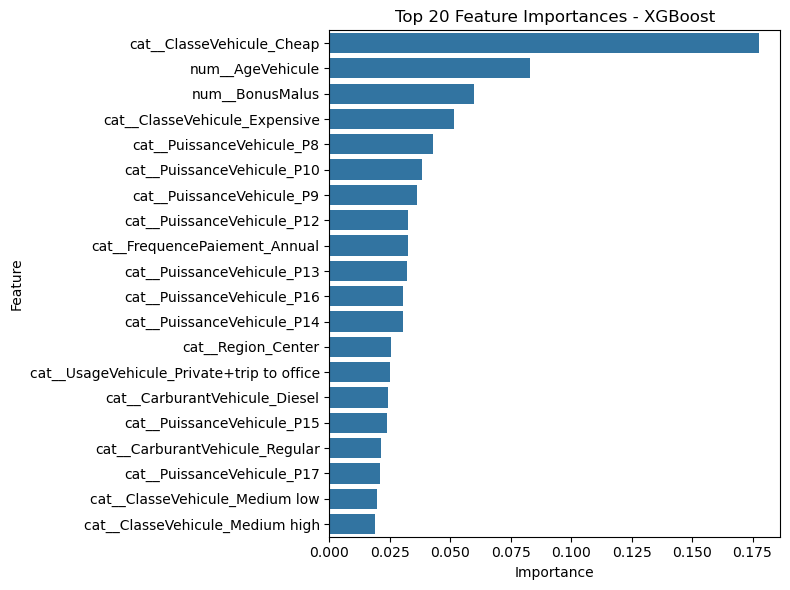

In [45]:
top_k = 20
top_features = feature_importance_df.head(top_k)

plt.figure(figsize=(8, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_features
)
plt.title(f'Top {top_k} Feature Importances - XGBoost')
plt.tight_layout()
plt.show()


---
SHAP
---

In [46]:
# SHAP Feature Importance for XGBoost with Pipeline
# Extract the preprocessor and model from the pipeline
preprocessor_xgb = xgb.named_steps['preprocess']
xgb_model = xgb.named_steps['model']

# Preprocess the test data
X_test_preprocessed = preprocessor_xgb.transform(X_test)

# Create SHAP explainer with the raw XGBoost model (not the pipeline)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_preprocessed)

In [47]:
#define num_var and cat_var for feature names extraction
num_var = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_var = X.select_dtypes(include=['object', 'category']).columns.tolist()

#  Get feature names after preprocessing
feature_names = (
    list(preprocessor_xgb.named_transformers_['num'].get_feature_names_out(num_var)) +
    list(preprocessor_xgb.named_transformers_['cat'].get_feature_names_out(cat_var))
)

print(f"Total features after preprocessing: {len(feature_names)}")

Total features after preprocessing: 41


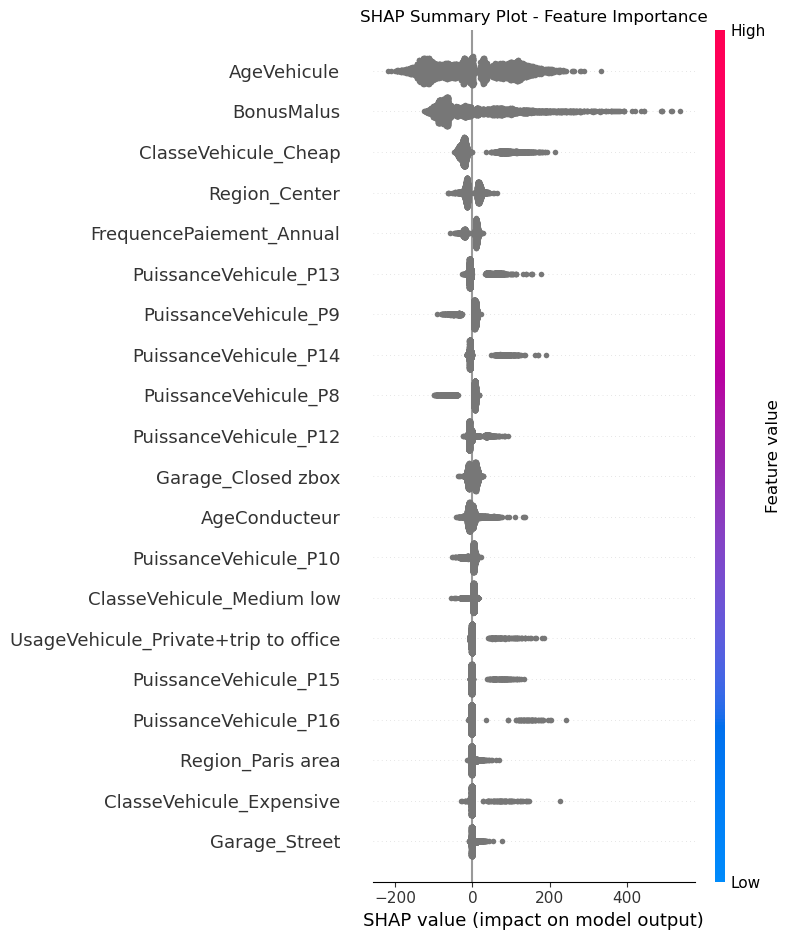

In [48]:
# SHAP summary plots
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Feature Importance")
plt.tight_layout()
plt.show()

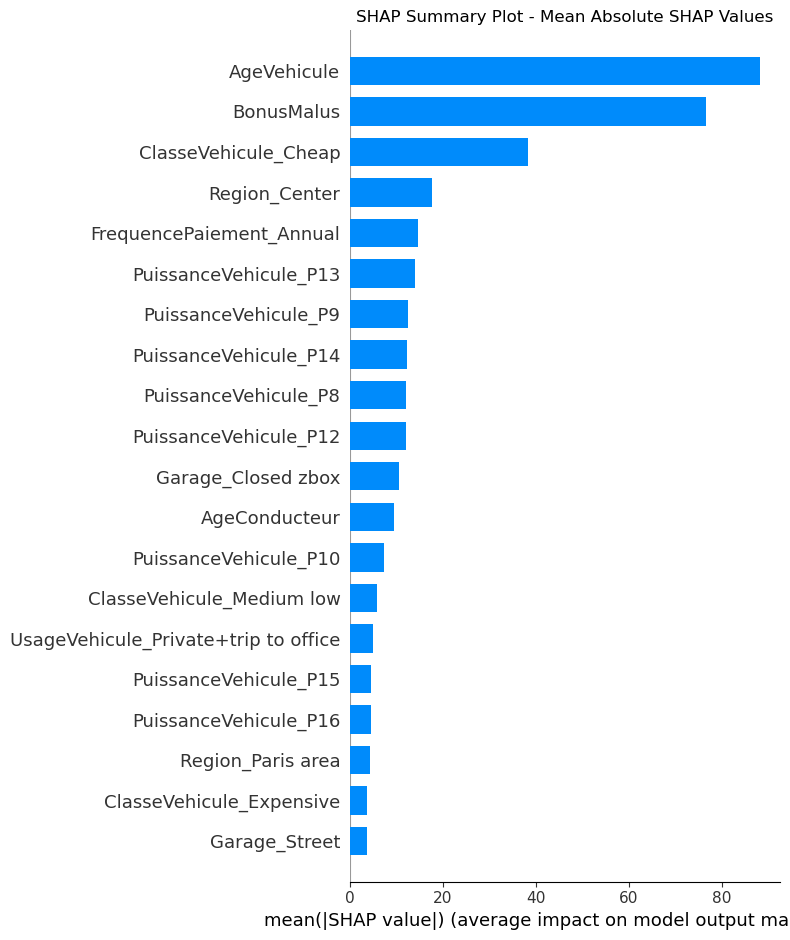

In [49]:
# Bar plot (mean absolute SHAP values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Mean Absolute SHAP Values")
plt.tight_layout()
plt.show()


In [50]:
# Important features
features_idx = np.argsort(np.abs(shap_values).mean(axis=0))
print("\ Important features:")
for idx in reversed(features_idx):
    print(f"  {feature_names[idx]}: {np.abs(shap_values[:, idx]).mean():.4f}")

\ Important features:
  AgeVehicule: 88.1671
  BonusMalus: 76.5496
  ClasseVehicule_Cheap: 38.4026
  Region_Center: 17.7024
  FrequencePaiement_Annual: 14.6080
  PuissanceVehicule_P13: 13.9572
  PuissanceVehicule_P9: 12.4875
  PuissanceVehicule_P14: 12.1632
  PuissanceVehicule_P8: 12.0342
  PuissanceVehicule_P12: 11.9753
  Garage_Closed zbox: 10.5184
  AgeConducteur: 9.3844
  PuissanceVehicule_P10: 7.3733
  ClasseVehicule_Medium low: 5.6963
  UsageVehicule_Private+trip to office: 4.9363
  PuissanceVehicule_P15: 4.5674
  PuissanceVehicule_P16: 4.4348
  Region_Paris area: 4.2382
  ClasseVehicule_Expensive: 3.6118
  Garage_Street: 3.5928
  CarburantVehicule_Diesel: 3.0303
  FrequencePaiement_Quarterly: 2.6307
  PuissanceVehicule_P11: 2.5764
  Garage_Opened collective parking: 2.5567
  PuissanceVehicule_P7: 2.4539
  ClasseVehicule_Medium high: 2.0128
  Region_Headquarters: 1.9907
  PuissanceVehicule_P5: 1.9693
  FrequencePaiement_Monthly: 1.9529
  Garage_Closed collective parking: 1.9042
 